# TASK 1: Single RUL Regressor for DS08  
(organizing the project by task and notebook)
- using the data from dev and test sets for DS08 (the dataset that contains all failures)  
    I first tried this with the first set, the dataset that contains only one failure mode, but it didn't have as many units and I ran into issues with splitting the data up. We should revisit this together tho (anything that I do or say we should always go over again together if there is any doubt)
- build a RUL regressor that predicts the RUL
### imports

In [7]:
import os
import pickle
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.stats as stats
import math
import random
import gc
import multiprocessing as mp

In [88]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, InputLayer, Dense, Conv1D, BatchNormalization, Flatten, Dropout
%matplotlib inline

## LOAD the data

In [2]:
df = pd.read_csv('df08_rul_reg.csv')
df_aux = pd.read_csv('df08_aux_rul_reg.csv')

# drop the first column, alternatively handle it better during saving/loading
df.drop(columns=[df.columns[0]], inplace=True)
df_aux.drop(columns=[df_aux.columns[0]], inplace=True)

## LOAD the labels

In [3]:
y_labels = []
with open("y_labels.txt", "r") as f:
    for l in f:
        y_labels.append(l.strip())
        
t_labels = []
with open("t_labels.txt", "r") as f:
    for l in f:
        t_labels.append(l.strip())
        
print(y_labels)
print(t_labels)

['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']
['alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


### Split the set up by flight class

In [4]:
df1 = df[df.Fc == 1]
df2 = df[df.Fc == 2]
df3 = df[df.Fc == 3]
print(f"Fc1 units: {pd.unique(df1.ui)}")
print(f"Fc2 units: {pd.unique(df2.ui)}")
print(f"Fc3 units: {pd.unique(df3.ui)}")

Fc1 units: [ 0  2  8  9 14]
Fc2 units: [ 3  4  6  7 10 20 21 22 23 24]
Fc3 units: [ 1  5 11 12 13 15 16 17 18 19]


### Split the set up by train, val, test

In [5]:
def train_test_split(df, y_labels, t_labels, verbose=False):
    ui = list(pd.unique(df.ui))
    samples = len(ui)
    if verbose:
        print(f"unit unique identifier (ui): {ui}")
        print(f"number of units: {samples}")
    
    train_pct = .65
    val_pct = .2
    test_pct = .15
    train_start = 0
    train_cnt = int(samples*train_pct)
    val_cnt = int(samples*val_pct)
    test_cnt = int(samples*test_pct)+1
    if verbose:
        print(f"train, val, test set counts: {train_cnt}, {val_cnt}, {test_cnt}")
    
    assert train_cnt + val_cnt + test_cnt == samples, "error"

    train_ui = random.sample(ui, train_cnt)
    ui = list(set(ui) - set(train_ui))
    val_ui = random.sample(ui, val_cnt)
    ui = list(set(ui) - set(val_ui))
    test_ui = random.sample(ui, test_cnt)
    ui = list(set(ui) - set(test_ui))
    
    assert len(ui) == 0, "error"
    
    if verbose:
        print(f"train ui: {train_ui}")
        print(f"val ui: {val_ui}")
        print(f"test ui: {test_ui}")
    
    train_df = df[df['ui'].isin(train_ui)]
    val_df = df[df['ui'].isin(val_ui)]
    test_df = df[df['ui'].isin(test_ui)]
    
    train_y = np.array(train_df.y, dtype=np.int32)
    val_y = np.array(val_df.y, dtype=np.int32)
    test_y = np.array(test_df.y, dtype=np.int32)
    
    train_deg = train_df[y_labels]
    val_deg = val_df[y_labels]
    test_deg = test_df[y_labels]
    
    train_df = pd.concat([train_df[t_labels], train_deg], axis=1)
    val_df = pd.concat([val_df[t_labels], val_deg], axis=1)
    test_df = pd.concat([test_df[t_labels], test_deg], axis=1)
    
    return train_df, train_y, val_df, val_y, test_df, test_y

### Flight class 1 train, val, test sets

In [8]:
train1_df, train1_y, val1_df, val1_y, test1_df, test1_y = train_test_split(df1, y_labels, t_labels, verbose=True)

unit unique identifier (ui): [0, 2, 8, 9, 14]
number of units: 5
train, val, test set counts: 3, 1, 1
train ui: [9, 0, 8]
val ui: [14]
test ui: [2]


### Flight class 2 train, val, test sets

In [9]:
train2_df, train2_y, val2_df, val2_y, test2_df, test2_y = train_test_split(df2, y_labels, t_labels, verbose=True)

unit unique identifier (ui): [3, 4, 6, 7, 10, 20, 21, 22, 23, 24]
number of units: 10
train, val, test set counts: 6, 2, 2
train ui: [20, 24, 10, 7, 21, 4]
val ui: [23, 22]
test ui: [6, 3]


### Flight class 3 train, val, test sets

In [10]:
train3_df, train3_y, val3_df, val3_y, test3_df, test3_y = train_test_split(df3, y_labels, t_labels, verbose=True)

unit unique identifier (ui): [1, 5, 11, 12, 13, 15, 16, 17, 18, 19]
number of units: 10
train, val, test set counts: 6, 2, 2
train ui: [17, 13, 15, 18, 1, 19]
val ui: [5, 16]
test ui: [11, 12]


### Now we have 3 models to train, one for each flight class

One dimensional convolutional neural network architecture (1-d CNN). The architecture of the CNN neural network used in this research also comprises five layers (L = 5). The network has three initial convolutional layers with filters of size 10. The first two convolutions have ten channels and the last convolution has only one channel. Zero padding is used to keep the feature map through the network. The resulting 2D feature map is flattened and the network ends with a 50-way fully connected layer followed by a linear output neuron. The network uses ReLu as the activation function. The network has 24k trainable parameters (H). Similarly as for the FNN, the final architecture is the result of conducting a grid-search over the following hyperparameters: number of hidden layers [1-4], number of channels [10, 20, 30] at each convolutional layer, filter size [10, 20], number of neurons at the fully connected layer [50, 100], activation function type [tanh, relu], and window size of the siding window [20, 50, 200].

mini-batch stochastic gradient discent, batch size = 1024 learning rate .001, 60 epochs for FNN and 30 epochs for CNN, patience of 5 epochs

### STEPS
1. temporalize
2. standardize

In [11]:
def temporalize_data(inputs, outputs, lookback, horizon, n_features, n_out):
        """
            @brief: reshapes a dataset to account for time

            @params:
                inputs: the 'X' vector (what you are training on)
                outputs: the 'y' vector (what you are predicting)
                lookback: the number of samples in the lookback period (NOTE: not
                            the same as lookback_hours)
                horizon: the number of samples in the horizon period (NOTE: not
                            the same as horizon_hours)
                n_features: the number of features in inputs (X)
                n_out: the number of outputs in outputs (y)

            @returns:
                X_out: a 3d numpy matrix of size [sz, lookback, n_features]
                y: a 3d numpy matrix of size [sz, horizon, n_out]
        """
        X_out = []
        y = []
        ################# the number of samples to generate accounts for the lookback and horizon size
        sz = (len(inputs) - (lookback + horizon) - 1)
        for i in range(0, sz):
            temp = []
            for j in range(0, lookback):
                ################# temp stacks sequential observations and creates a single sample
                temp.append(inputs[[i + j]])
            ################# X_out[0] is now a single sample array with the first [0 - <lookback>] observations
            X_out.append(temp)
            temp = []
            if (len(outputs) > 0):
                ################# the subsequent observations are the values to predict
                for j in range(lookback, lookback + horizon):
                    temp.append(outputs[[i + j]])
                ################# y[0] is now a single sample array with the first [<lookback> - <horizon>] observations
                y.append(temp)
        ################# convert to numpy arrays and reshape for LSTM input
        X_out = np.array(X_out)
        X_out = X_out.reshape(X_out.shape[0], lookback, n_features)
        y = np.array(y)
        y = y.reshape(y.shape[0], horizon, n_out)
        return X_out, y


In [12]:
# 20 timesteps back
lookback = 20

# 1 timestep forward
horizon = 1

# df columns
n_features = len(train1_df.columns)

# rul
n_out = 1 

# flight class 1
X_train1, y_train1 = temporalize_data(np.array(train1_df), train1_y, lookback, horizon, n_features, n_out)
X_test1, y_test1 = temporalize_data(np.array(test1_df), test1_y, lookback, horizon, n_features, n_out)
X_val1, y_val1 = temporalize_data(np.array(val1_df), val1_y, lookback, horizon, n_features, n_out)

# flight class 2
X_train2, y_train2 = temporalize_data(np.array(train2_df), train2_y, lookback, horizon, n_features, n_out)
X_test2, y_test2 = temporalize_data(np.array(test2_df), test2_y, lookback, horizon, n_features, n_out)
X_val2, y_val2 = temporalize_data(np.array(val2_df), val2_y, lookback, horizon, n_features, n_out)

# flight class 3
X_train3, y_train3 = temporalize_data(np.array(train3_df), train3_y, lookback, horizon, n_features, n_out)
X_test3, y_test3 = temporalize_data(np.array(test3_df), test3_y, lookback, horizon, n_features, n_out)
X_val3, y_val3 = temporalize_data(np.array(val3_df), val3_y, lookback, horizon, n_features, n_out)

### Standardize the data

In [13]:
mu1 = np.mean(X_train1)
std1 = np.std(X_train1)

X_train1 = X_train1 - mu1 / std1
X_test1 = X_test1 - mu1 / std1
X_val1 = X_val1 - mu1 / std1

mu2 = np.mean(X_train2)
std2 = np.std(X_train2)

X_train2 = X_train2 - mu2 / std2
X_test2 = X_test2 - mu2 / std2
X_val2 = X_val2 - mu2 / std2

mu3 = np.mean(X_train3)
std3 = np.std(X_train3)

X_train3 = X_train3 - mu3 / std3
X_test3 = X_test3 - mu3 / std3
X_val3 = X_val3 - mu3 / std3



### the shape should now be (num_samples, num_timesteps, num_features)

In [36]:
X_train1.shape

(96644, 20, 28)

In [37]:
y_train1.shape

(96644, 1, 1)

## BUILD and TRAIN the model

Model: "fc1_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cl1 (Conv1D)                 (None, 20, 10)            2810      
_________________________________________________________________
cl2 (Conv1D)                 (None, 20, 10)            1010      
_________________________________________________________________
cl3 (Conv1D)                 (None, 20, 1)             101       
_________________________________________________________________
l4 (Flatten)                 (None, 20)                0         
_________________________________________________________________
dl1 (Dense)                  (None, 50)                1050      
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 5,022
Trainable params: 5,022
Non-trainable params: 0
_________________________________________________________

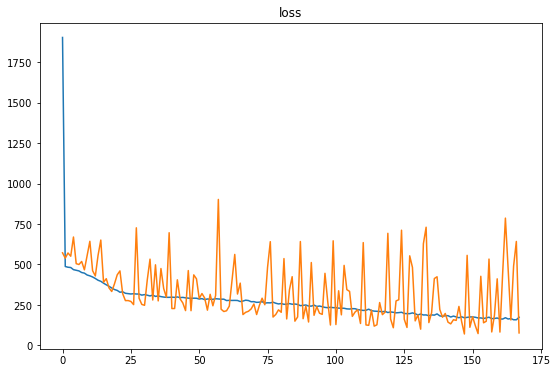

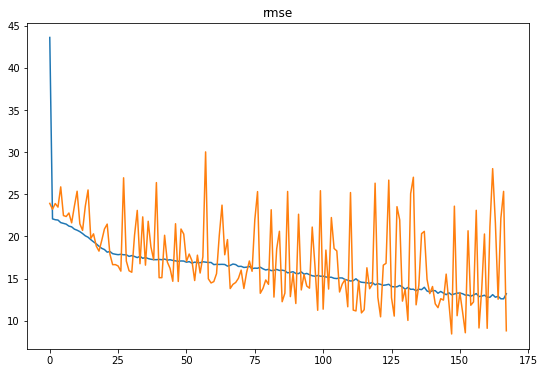

In [114]:
# early stopping parameters
min_delta = 5
patience = 20

# compile parameters
lr = .00005

# fit parameters
batch_size = 32
epochs = 500

model = Sequential(name='fc1_cnn')
model.add(InputLayer(input_shape=(lookback, n_features), name='input'))

# I standardized above because I wasn't sure how exactly this is working, need to read more how to use it
#model.add(BatchNormalization(name='bn'))
model.add(Conv1D(filters=10, kernel_size=10, strides=1, padding='same', activation='relu', kernel_initializer='glorot_uniform', name='cl1'))
model.add(Conv1D(filters=10, kernel_size=10, strides=1, padding='same', activation='relu', kernel_initializer='glorot_uniform', name='cl2'))
model.add(Conv1D(filters=1, kernel_size=10, strides=1, padding='same', activation='relu', kernel_initializer='glorot_uniform', name='cl3'))
model.add(Flatten(name='l4'))
model.add(Dense(units=50, kernel_initializer='glorot_uniform', activation='relu', name='dl1'))
#model.add(Dropout(rate=.25, name='do1'))
model.add(Dense(units=1, name='output'))


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               mode='min', 
                                               min_delta=min_delta, 
                                               patience=patience, 
                                               verbose=1,
                                               restore_best_weights=True)

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=[keras.metrics.RootMeanSquaredError()])

model.summary()

history = model.fit(X_train1, y_train1, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_val1, y_val1),
                    callbacks=[early_stopping])


fig = plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("rmse")
plt.show()

## EVALUATE the model

In [115]:
model.evaluate(X_test1, y_test1, batch_size=32, verbose=1)

1250/1250 [==============================] - 2s 2ms/step - loss: 268.3705 - root_mean_squared_error: 16.3820


[268.3705139160156, 16.382017135620117]

In [116]:
y_pred = model.predict(X_test1)

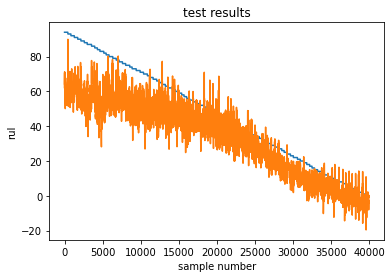

In [128]:
fig = plt.figure
plt.plot(y_test1.reshape(-1,1), label='true')
plt.plot(y_pred, label='pred')
plt.title("test results")
plt.xlabel("sample number")
plt.ylabel("rul")
plt.show()

How to map the results back to unit and cycle when this information is lost during training?

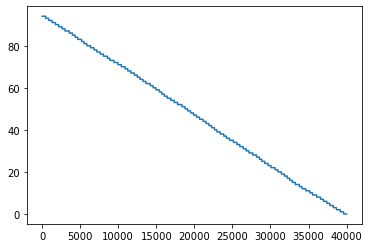

In [125]:
plt.plot(test1_y)
plt.show()

In [126]:
y_pred.shape

### Monday work
- implement custom CNN model with functional api
- add batch normalization
- previous model had "jumpy" loss due to small batch size and high batch-to-batch variance - how to address?

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import mnist, cifar10
import numpy as np
import pandas as pd

print(tf.__version__)
gpu = tf.config.list_physical_devices('GPU')
has_gpu = gpu[0][0].split(':')[1] == 'GPU'
print(f"[INFO] GPU?: <{has_gpu}> {gpu}")
if(has_gpu):
    tf.config.experimental.set_memory_growth(gpu[0], True)


2.5.0
[INFO] GPU?: <True> [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
def make_model():
    inputs = keras.Input(shape=(lookback, n_features), name='in1')
    
    x = layers.Conv1D(filters=n_features, kernel_size=5, strides=1, padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    
    x = layers.Conv1D(filters=n_features, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(.01))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    
    x = layers.Conv1D(filters=1, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(.01))(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
    
    #x = layers.Dropout(rate=.2)(x)
    
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

model = make_model()
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in1 (InputLayer)             [(None, 20, 28)]          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 20, 28)            3948      
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 28)            112       
_________________________________________________________________
tf.nn.relu_15 (TFOpLambda)   (None, 20, 28)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 20, 28)            2380      
_________________________________________________________________
batch_normalization_16 (Batc (None, 20, 28)            112       
_________________________________________________________________
tf.nn.relu_16 (TFOpLambda)   (None, 20, 28)            0   

# flight class 1

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in1 (InputLayer)             [(None, 20, 28)]          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 20, 28)            3948      
_________________________________________________________________
batch_normalization_21 (Batc (None, 20, 28)            112       
_________________________________________________________________
tf.nn.relu_21 (TFOpLambda)   (None, 20, 28)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 20, 28)            2380      
_________________________________________________________________
batch_normalization_22 (Batc (None, 20, 28)            112       
_________________________________________________________________
tf.nn.relu_22 (TFOpLambda)   (None, 20, 28)            0   

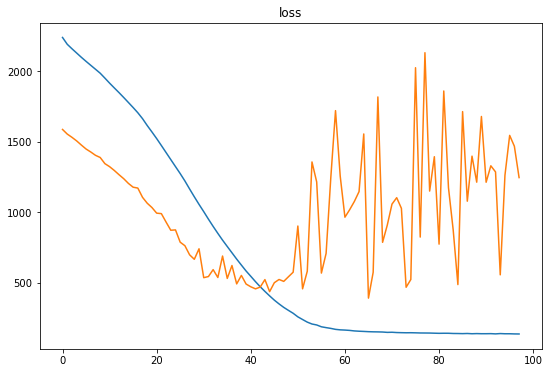

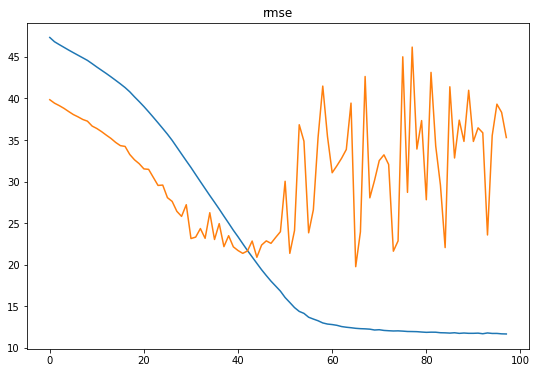

1064/1064 [==============================] - 2s 2ms/step - loss: 174.6475 - root_mean_squared_error: 13.1759


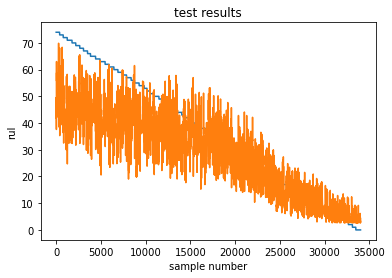

In [25]:
# early stopping parameters
#min_delta = 8
min_delta = 24
patience = 32

# compile parameters
#lr = .00005
lr = .00001

# fit parameters
batch_size = 256
epochs = 1000


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               mode='min', 
                                               min_delta=min_delta, 
                                               patience=patience, 
                                               verbose=1,
                                               restore_best_weights=True)

model = make_model()

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=[keras.metrics.RootMeanSquaredError()])

model.summary()

history = model.fit(X_train1, y_train1, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_val1, y_val1),
                    callbacks=[early_stopping])


fig = plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("rmse")
plt.show()

model.evaluate(X_test1, y_test1, batch_size=32, verbose=1)

y_pred = model.predict(X_test1)

fig = plt.figure
plt.plot(y_test1.reshape(-1,1), label='true')
plt.plot(y_pred, label='pred')
plt.title("test results")
plt.xlabel("sample number")
plt.ylabel("rul")
plt.show()

# Flight class 2

C:\Users\lab\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in1 (InputLayer)             [(None, 20, 28)]          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 20, 28)            3948      
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 28)            112       
_________________________________________________________________
tf.nn.relu_24 (TFOpLambda)   (None, 20, 28)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 20, 28)            2380      
_________________________________________________________________
batch_normalization_25 (Batc (None, 20, 28)            112       
_________________________________________________________________
tf.nn.relu_25 (TFOpLambda)   (None, 20, 28)            0   

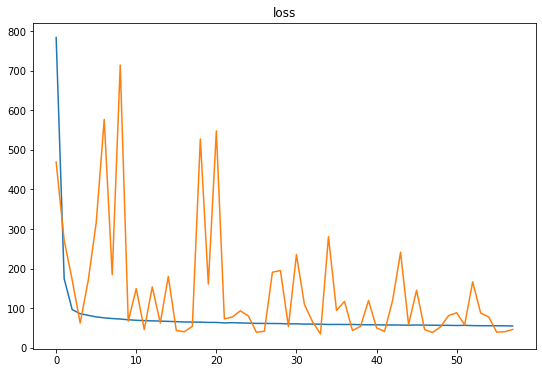

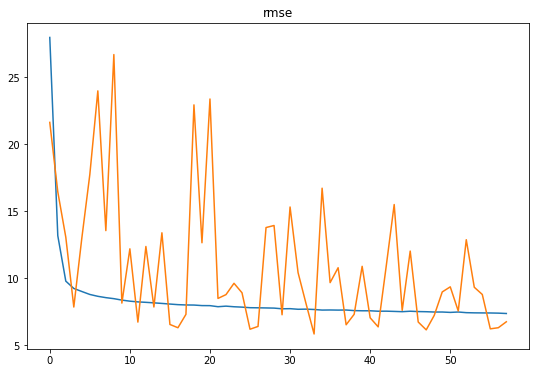

3781/3781 [==============================] - 9s 2ms/step - loss: 63.1134 - root_mean_squared_error: 7.8885


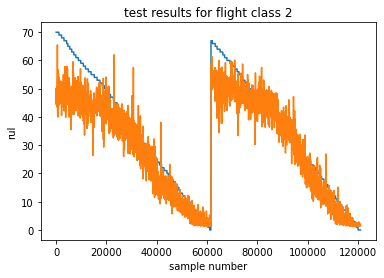

In [26]:
# early stopping parameters
min_delta = 8
#min_delta = 
patience = 24

# compile parameters
#lr = .00005
lr = .000025

# fit parameters
batch_size = 64
epochs = 500


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               mode='min', 
                                               min_delta=min_delta, 
                                               patience=patience, 
                                               verbose=1,
                                               restore_best_weights=True)

model = make_model()

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=[keras.metrics.RootMeanSquaredError()])

model.summary()

history = model.fit(X_train2, y_train2, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_val2, y_val2),
                    callbacks=[early_stopping])


fig = plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("rmse")
plt.show()

model.evaluate(X_test2, y_test2, batch_size=32, verbose=1)

y_pred = model.predict(X_test2)

fig = plt.figure
plt.plot(y_test2.reshape(-1,1), label='true')
plt.plot(y_pred, label='pred')
plt.title("test results for flight class 2")
plt.xlabel("sample number")
plt.ylabel("rul")
plt.show()

# Flight Class 3

C:\Users\lab\envs\tf2gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in1 (InputLayer)             [(None, 20, 28)]          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 20, 28)            3948      
_________________________________________________________________
batch_normalization_27 (Batc (None, 20, 28)            112       
_________________________________________________________________
tf.nn.relu_27 (TFOpLambda)   (None, 20, 28)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 20, 28)            2380      
_________________________________________________________________
batch_normalization_28 (Batc (None, 20, 28)            112       
_________________________________________________________________
tf.nn.relu_28 (TFOpLambda)   (None, 20, 28)            0   

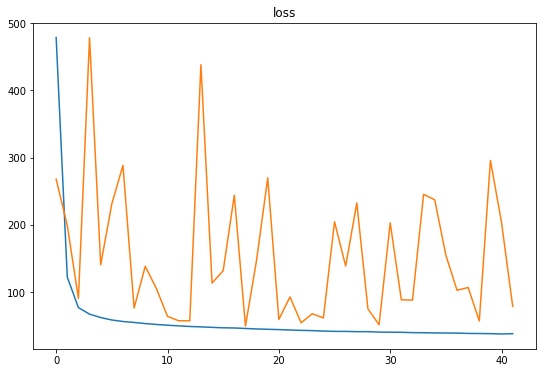

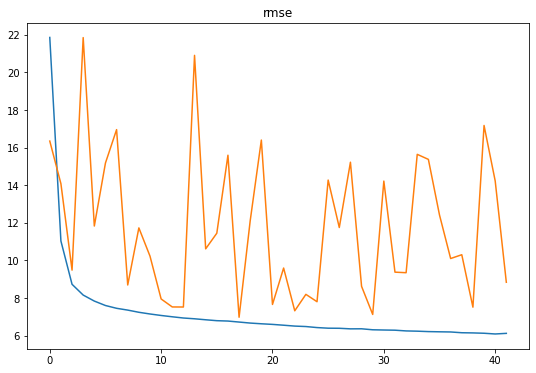

5316/5316 [==============================] - 13s 2ms/step - loss: 120.8469 - root_mean_squared_error: 10.9531


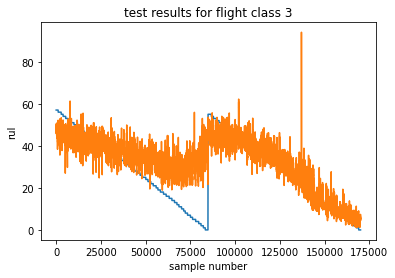

In [27]:
# early stopping parameters
min_delta = 8
#min_delta = 
patience = 24

# compile parameters
#lr = .00005
lr = .000025

# fit parameters
batch_size = 64
epochs = 500


early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               mode='min', 
                                               min_delta=min_delta, 
                                               patience=patience, 
                                               verbose=1,
                                               restore_best_weights=True)
model = make_model()

model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=[keras.metrics.RootMeanSquaredError()])

model.summary()

history = model.fit(X_train3, y_train3, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_val3, y_val3),
                    callbacks=[early_stopping])


fig = plt.figure(figsize=(9,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("rmse")
plt.show()

model.evaluate(X_test3, y_test3, batch_size=32, verbose=1)

y_pred = model.predict(X_test3)

fig = plt.figure
plt.plot(y_test3.reshape(-1,1), label='true')
plt.plot(y_pred, label='pred')
plt.title("test results for flight class 3")
plt.xlabel("sample number")
plt.ylabel("rul")
plt.show()

## Thoughts
- split the sets up as we described and train a model on the linear portion and a separate model on the non linear portion
- flight class 2 seemed to perform much better than 1 or 3, but also we should try multiple times with different unit splits
- flight class 3 had one unit do really bad, and another unit do the best out of all

# Tuesday
- bilstm with residual connections using subclassing


# Wednesday
- custom loss and training functions

(39971, 1)